In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor,Qwen2VLForConditionalGeneration
# from transformers import AutoProcessor,Qwen2VLForConditionalGeneration
import numpy as np
from qwen_vl_utils import process_vision_info

local_path = "/cpfs04/shared/CausaLLMs/HuggingfaceModels/Qwen2.5-VL-7B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    local_path, torch_dtype="auto", device_map="auto"
)

# local_path = "/cpfs04/shared/CausaLLMs/HuggingfaceModels/QVQ-72B-Preview"

# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     local_path, torch_dtype="auto", device_map="auto"
# )

processor = AutoProcessor.from_pretrained(local_path)

/root/miniconda3/envs/yjenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-28 11:36:03.408845: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 11:36:03.422993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743132963.439145 1837107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743132963.443913 1837107 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743132963.456813 1837107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [17]:
import re
def evaluate_image(image_path,image_size) -> str:
    """
    Evaluates the given image for internal visual consistency and returns a score.
    
    The evaluation is performed by prompting the model with a message asking to rate the image
    from 0 (inconsistent) to 10 (completely harmonious and consistent), following the format:
    "The score is {your_score}. The reason is {your_reason}."
    
    Args:
        image_path (str): The path to the image.
    
    Returns:
        str: The generated output text containing the score and the reason.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path,"resized_height":image_size,"resized_width":image_size},
                {"type": "text", "text": (
                    "You're an expert in understanding images. Each image can be divided into 4 numbers along the horizontal and vertical midlines. First, identify these 4 numbers separately, calculate their sum, and check if it's 24. If yes, label it as 1; otherwise, label it as 0."
                    "Please think this step by step and answer in the the format: The label is {your_label}. The reason is {your_reason}."
                )},
            ],
        }
    ]

    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=1000)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    # 返回生成的评分信息（例如字符串形式）

    # print("image_path:",image_path,"output_text:",output_text)
    # return extract_score_after_final_answer(output_text) 
    pattern = r"(?i)(?:The\s+label is)[\s:-]*(\d+)"
    match = re.search(pattern, output_text[0])
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Score not found in output: {output_text[0]}")

import re

def extract_score_after_final_answer(output_text):
    """
    从给定文本中查找 **Final Answer** 后面出现的第一个数字，并返回其整数值。
    如果未找到，则抛出 ValueError。
    """
    # 若 output_text 是列表，则默认取第一个元素
    if isinstance(output_text, list):
        text_to_search = output_text[0]
    else:
        text_to_search = output_text

    # 正则：匹配 "**Final Answer**" 后，任意字符(含换行)，再遇到数字(\d+)
    pattern = r"\*\*Final Answer\*\*.*?(\d+)"
    match = re.search(pattern, text_to_search, re.DOTALL)

    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"No number found after **Final Answer** in: {text_to_search}")


In [13]:
import re

def extract_label(text):
    # 增强版正则表达式，处理多种文本格式
    pattern = r"(?i)(?:The\s+label is)[\s:-]*(\d+)"
    match = re.search(pattern, text)
    
    if match:
        return int(match.group(1))
    else:
        # 调试模式：显示所有潜在匹配
        debug_matches = re.findall(r'\d+', text)
        raise ValueError(f"未找到标签值，文本中所有数字：{debug_matches}")

# 测试用例
test_text = "Therefore, the label is 1 because the sum of the numbers is 24. The label is 1. The reason is the sum of the numbers 2, 8, 7, and 7 is 24."
print(extract_label(test_text))  # 输出: 1

1


In [18]:
import os
import random
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm
import tempfile
image_dir = "/cpfs04/user/hanyujin/rule-gen/datasets/mnist-mnist/images"
image_dir_1 = "/cpfs04/user/hanyujin/causal-dm/results/mnist-mnist_unet/vis/epoch_500_1743129768.0850055"
image_dir_2 = "/cpfs04/user/hanyujin/causal-dm/AR_diff/results/mnist-mnist_parallelFalse_reverseFalse_patch32_dim480_depth6_mlpdepth3_noweightedlossTrue_trainsteps125000_mlp/generations/checkpoint.125000"
# 获取所有 PNG 文件
image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
image_files_1 = [f for f in os.listdir(image_dir_1) if f.endswith(".png")]
image_files_2 = [f for f in os.listdir(image_dir_2) if f.endswith(".png")]
# 随机采样100张图片（如果图片总数不足，则全部使用）
sample_size = min(10, len(image_files))
sampled_files = random.sample(image_files, sample_size) #sorted(image_files)[:sample_size] #random.sample(image_files_1, sample_size)

sample_size = min(10, len(image_files_1))
sampled_files_1 = random.sample(image_files_1, sample_size) #sorted(image_files_1)[:sample_size] #random.sample(image_files_1, sample_size)

sample_size = min(10, len(image_files_2))
sampled_files_2 = random.sample(image_files_2, sample_size) #sorted(image_files_2)[:sample_size] #random.sample(image_files_2, sample_size)

image_size = 256

In [19]:
# image_size = 64
scores_original = []
running_sum = 0
valid_count = 0
pbar = tqdm(sampled_files, desc="Processing Raw Images")
for image_name in pbar:
    image_path = os.path.join(image_dir, image_name)
    try:
        score = evaluate_image(image_path,image_size)
    except Exception as e:
        print(f"Error evaluating original image {image_name}: {e}")
        score = None

    if score is not None:
        running_sum += score
        valid_count += 1

    scores_original.append(score)
    print("Train image scores:", scores_original)
    avg_score = running_sum / valid_count if valid_count > 0 else 0
    pbar.set_postfix(avg_score=f"{avg_score:.4f}")
print("Train image scores:", scores_original)

Processing Raw Images:  10%|█         | 1/10 [00:05<00:46,  5.13s/it, avg_score=0.0000]

Error evaluating original image combined_0168.png: Score not found in output: Let's break down the image into its four numbers:

1. The number at the top-left corner is \(0\).
2. The number at the top-right corner is \(7\).
3. The number at the bottom-left corner is \(9\).
4. The number at the bottom-right corner is \(8\).

Now, let's add these numbers together:
\[0 + 7 + 9 + 8 = 24\]

Since the sum of these numbers is indeed 24, we can conclude that the label should be 1.

The label is \(\boxed{1}\). The reason is that the sum of the numbers \(0 + 7 + 9 + 8\) equals 24.
Train image scores: [None]


Processing Raw Images:  20%|██        | 2/10 [00:09<00:37,  4.68s/it, avg_score=0.0000]

Error evaluating original image combined_1857.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 4
2. Top right number: 7
3. Bottom left number: 2
4. Bottom right number: 8

Now, let's add these numbers together:
\[ 4 + 7 + 2 + 8 = 21 \]

The sum of these numbers is 21, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (4 + 7 + 2 + 8) is 21, not 24.
Train image scores: [None, None]


Processing Raw Images:  30%|███       | 3/10 [00:13<00:31,  4.51s/it, avg_score=1.0000]

Train image scores: [None, None, 1]


Processing Raw Images:  40%|████      | 4/10 [00:18<00:27,  4.60s/it, avg_score=1.0000]

Train image scores: [None, None, 1, 1]


Processing Raw Images:  50%|█████     | 5/10 [00:22<00:22,  4.47s/it, avg_score=1.0000]

Train image scores: [None, None, 1, 1, 1]


Processing Raw Images:  60%|██████    | 6/10 [00:27<00:17,  4.40s/it, avg_score=1.0000]

Train image scores: [None, None, 1, 1, 1, 1]


Processing Raw Images:  70%|███████   | 7/10 [00:31<00:13,  4.45s/it, avg_score=1.0000]

Error evaluating original image combined_0110.png: Score not found in output: Let's break down the image into the four numbers:

1. Top left number: 6
2. Top right number: 3
3. Bottom left number: 4
4. Bottom right number: 9

Now, let's add these numbers together:
\[ 6 + 3 + 4 + 9 = 22 \]

The sum of the four numbers is 22, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (6 + 3 + 4 + 9) is 22, not 24.
Train image scores: [None, None, 1, 1, 1, 1, None]


Processing Raw Images:  80%|████████  | 8/10 [00:36<00:08,  4.44s/it, avg_score=1.0000]

Error evaluating original image combined_0210.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 63
2. Top right number: 9
3. Bottom left number: 6
4. Bottom right number: 6

Now, let's add these numbers together:
\[ 63 + 9 + 6 + 6 = 84 \]

The sum of these numbers is 84, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (63, 9, 6, 6) is 84, not 24.
Train image scores: [None, None, 1, 1, 1, 1, None, None]


Processing Raw Images:  90%|█████████ | 9/10 [00:40<00:04,  4.54s/it, avg_score=1.0000]

Error evaluating original image combined_0969.png: Score not found in output: Let's break down the image into its four numbers:

1. The number at the top left is 7.
2. The number at the top right is 7.
3. The number at the bottom left is 7.
4. The number at the bottom right is 8.

Now, let's add these numbers together:
\[ 7 + 7 + 7 + 8 = 29 \]

The sum of the four numbers is 29, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (7 + 7 + 7 + 8) is 29, not 24.
Train image scores: [None, None, 1, 1, 1, 1, None, None, None]


Processing Raw Images: 100%|██████████| 10/10 [00:45<00:00,  4.51s/it, avg_score=1.0000]

Error evaluating original image combined_1109.png: Score not found in output: Let's break down the image into its four numbers:

1. Top left number: 8
2. Top right number: 6
3. Bottom left number: 2
4. Bottom right number: 9

Now, let's add these numbers together:
\[ 8 + 6 + 2 + 9 = 25 \]

The sum of the four numbers is 25, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (8, 6, 2, 9) is 25, not 24.
Train image scores: [None, None, 1, 1, 1, 1, None, None, None, None]
Train image scores: [None, None, 1, 1, 1, 1, None, None, None, None]


In [20]:
# 用于存储 Qwen 得分
scores_original_1 = []
running_sum = 0
valid_count = 0
pbar = tqdm(sampled_files_1, desc="Processing DDPM Images")
for image_name in pbar:
    image_path = os.path.join(image_dir_1, image_name)
    try:
        score = evaluate_image(image_path,image_size)
    except Exception as e:
        print(f"Error evaluating original image {image_name}: {e}")
        score = None

    if score is not None:
        running_sum += score
        valid_count += 1

    scores_original_1.append(score)
    print("DDPM image scores:", scores_original_1)
    avg_score = running_sum / valid_count if valid_count > 0 else 0
    pbar.set_postfix(avg_score=f"{avg_score:.4f}")
print("DDPM image scores:", scores_original_1)
# [2,]

Processing DDPM Images:  10%|█         | 1/10 [00:04<00:44,  4.95s/it, avg_score=0.0000]

Error evaluating original image sunshadow_188.png: Score not found in output: Let's break down the image into four numbers:

1. The number on the top left appears to be 2.
2. The number on the top right appears to be 2.
3. The number on the bottom left appears to be 4.
4. The number on the bottom right appears to be 4.

Now, let's add these numbers together:
\[ 2 + 2 + 4 + 4 = 12 \]

The sum of these numbers is 12, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (2, 2, 4, 4) is 12, not 24.
DDPM image scores: [None]


Processing DDPM Images:  20%|██        | 2/10 [00:09<00:36,  4.61s/it, avg_score=0.0000]

Error evaluating original image sunshadow_59.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 9
2. Top right number: 8
3. Bottom left number: 6
4. Bottom right number: 5

Now, let's add these numbers together:
\[ 9 + 8 + 6 + 5 = 28 \]

The sum of the four numbers is 28, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (9 + 8 + 6 + 5) is 28, not 24.
DDPM image scores: [None, None]


Processing DDPM Images:  30%|███       | 3/10 [00:13<00:31,  4.47s/it, avg_score=0.0000]

Error evaluating original image sunshadow_105.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 6
2. Top right number: 2
3. Bottom left number: 9
4. Bottom right number: 3

Now, let's add these numbers together:
\[ 6 + 2 + 9 + 3 = 20 \]

The sum of the numbers is 20, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (6 + 2 + 9 + 3) is 20, not 24.
DDPM image scores: [None, None, None]


Processing DDPM Images:  40%|████      | 4/10 [00:17<00:26,  4.41s/it, avg_score=0.0000]

Error evaluating original image sunshadow_159.png: Score not found in output: Let's break down the image into its four numbers:

1. Top-left number: 1
2. Top-right number: 8
3. Bottom-left number: 9
4. Bottom-right number: 8

Now, let's add these numbers together:
\[ 1 + 8 + 9 + 8 = 26 \]

The sum of the four numbers is 26, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (1 + 8 + 9 + 8) is 26, not 24.
DDPM image scores: [None, None, None, None]


Processing DDPM Images:  50%|█████     | 5/10 [00:22<00:21,  4.40s/it, avg_score=0.0000]

Error evaluating original image sunshadow_135.png: Score not found in output: Let's break down the image into the four numbers:

1. Top left number: 5
2. Top right number: 4
3. Bottom left number: 9
4. Bottom right number: 9

Now, let's add these numbers together:
\[ 5 + 4 + 9 + 9 = 27 \]

The sum of the four numbers is 27, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (5 + 4 + 9 + 9) is 27, not 24.
DDPM image scores: [None, None, None, None, None]


Processing DDPM Images:  60%|██████    | 6/10 [00:27<00:18,  4.58s/it, avg_score=0.0000]

Error evaluating original image sunshadow_150.png: Score not found in output: Let's break down the image into four numbers:

1. The number at the top left appears to be '5'.
2. The number at the top right appears to be '9'.
3. The number at the bottom left appears to be '8'.
4. The number at the bottom right appears to be '4'.

Now, let's add these numbers together:
\[ 5 + 9 + 8 + 4 = 26 \]

The sum of these numbers is 26, not 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (5, 9, 8, 4) is 26, which does not equal 24.
DDPM image scores: [None, None, None, None, None, None]


Processing DDPM Images:  70%|███████   | 7/10 [00:31<00:13,  4.63s/it, avg_score=0.0000]

Error evaluating original image sunshadow_56.png: Score not found in output: Let's break down the image into four numbers:

1. The top left number appears to be 9.
2. The top right number appears to be 6.
3. The bottom left number appears to be 9.
4. The bottom right number appears to be 7.

Now, let's add these numbers together:
\[ 9 + 6 + 9 + 7 = 31 \]

The sum of the numbers is 31, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (9 + 6 + 9 + 7) is 31, not 24.
DDPM image scores: [None, None, None, None, None, None, None]


Processing DDPM Images:  80%|████████  | 8/10 [00:36<00:09,  4.55s/it, avg_score=0.0000]

Error evaluating original image sunshadow_109.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 6
2. Top right number: 8
3. Bottom left number: 9
4. Bottom right number: 7

Now, let's add these numbers together:
\[ 6 + 8 + 9 + 7 = 30 \]

The sum of the four numbers is 30, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (6 + 8 + 9 + 7) is 30, not 24.
DDPM image scores: [None, None, None, None, None, None, None, None]


Processing DDPM Images:  90%|█████████ | 9/10 [00:40<00:04,  4.49s/it, avg_score=0.0000]

Error evaluating original image sunshadow_158.png: Score not found in output: Let's break down the image into four numbers:

1. Top-left number: 2
2. Top-right number: 4
3. Bottom-left number: 6
4. Bottom-right number: 6

Now, let's add these numbers together:
\[ 2 + 4 + 6 + 6 = 18 \]

The sum of the numbers is 18, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (2 + 4 + 6 + 6) is 18, not 24.
DDPM image scores: [None, None, None, None, None, None, None, None, None]


Processing DDPM Images: 100%|██████████| 10/10 [00:45<00:00,  4.55s/it, avg_score=0.0000]

Error evaluating original image sunshadow_160.png: Score not found in output: Let's break down the image into four numbers:

1. The top-left number appears to be 9.
2. The top-right number appears to be 5.
3. The bottom-left number appears to be 6.
4. The bottom-right number appears to be 8.

Now, let's add these numbers together:
\[ 9 + 5 + 6 + 8 = 28 \]

The sum of the numbers is 28, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (9 + 5 + 6 + 8) is 28, not 24.
DDPM image scores: [None, None, None, None, None, None, None, None, None, None]
DDPM image scores: [None, None, None, None, None, None, None, None, None, None]


In [21]:
# 用于存储 Qwen 得分
scores_original_1 = []
running_sum = 0
valid_count = 0
pbar = tqdm(sampled_files_1, desc="Processing DDPM Images")
for image_name in pbar:
    image_path = os.path.join(image_dir_1, image_name)
    try:
        score = evaluate_image(image_path,image_size)
    except Exception as e:
        print(f"Error evaluating original image {image_name}: {e}")
        score = None

    if score is not None:
        running_sum += score
        valid_count += 1

    scores_original_1.append(score)
    print("AR image scores:", scores_original_1)
    avg_score = running_sum / valid_count if valid_count > 0 else 0
    pbar.set_postfix(avg_score=f"{avg_score:.4f}")
print("AR image scores:", scores_original_1)
# [2,]

Processing DDPM Images:  10%|█         | 1/10 [00:04<00:44,  4.93s/it, avg_score=0.0000]

Error evaluating original image sunshadow_188.png: Score not found in output: Let's break down the image into four numbers:

1. The number on the top left appears to be 2.
2. The number on the top right appears to be 2.
3. The number on the bottom left appears to be 4.
4. The number on the bottom right appears to be 4.

Now, let's add these numbers together:
\[ 2 + 2 + 4 + 4 = 12 \]

The sum of these numbers is 12, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (2, 2, 4, 4) is 12, not 24.
AR image scores: [None]


Processing DDPM Images:  20%|██        | 2/10 [00:09<00:38,  4.75s/it, avg_score=0.0000]

Error evaluating original image sunshadow_59.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 9
2. Top right number: 8
3. Bottom left number: 6
4. Bottom right number: 5

Now, let's add these numbers together:
\[ 9 + 8 + 6 + 5 = 28 \]

The sum of the four numbers is 28, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (9 + 8 + 6 + 5) is 28, not 24.
AR image scores: [None, None]


Processing DDPM Images:  30%|███       | 3/10 [00:13<00:31,  4.53s/it, avg_score=0.0000]

Error evaluating original image sunshadow_105.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 6
2. Top right number: 2
3. Bottom left number: 9
4. Bottom right number: 3

Now, let's add these numbers together:
\[ 6 + 2 + 9 + 3 = 20 \]

The sum of the numbers is 20, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (6 + 2 + 9 + 3) is 20, not 24.
AR image scores: [None, None, None]


Processing DDPM Images:  40%|████      | 4/10 [00:18<00:27,  4.56s/it, avg_score=0.0000]

Error evaluating original image sunshadow_159.png: Score not found in output: Let's break down the image into its four numbers:

1. Top-left number: 1
2. Top-right number: 8
3. Bottom-left number: 9
4. Bottom-right number: 8

Now, let's add these numbers together:
\[ 1 + 8 + 9 + 8 = 26 \]

The sum of the four numbers is 26, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (1 + 8 + 9 + 8) is 26, not 24.
AR image scores: [None, None, None, None]


Processing DDPM Images:  50%|█████     | 5/10 [00:22<00:22,  4.54s/it, avg_score=0.0000]

Error evaluating original image sunshadow_135.png: Score not found in output: Let's break down the image into the four numbers:

1. Top left number: 5
2. Top right number: 4
3. Bottom left number: 9
4. Bottom right number: 9

Now, let's add these numbers together:
\[ 5 + 4 + 9 + 9 = 27 \]

The sum of the four numbers is 27, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (5 + 4 + 9 + 9) is 27, not 24.
AR image scores: [None, None, None, None, None]


Processing DDPM Images:  60%|██████    | 6/10 [00:27<00:18,  4.70s/it, avg_score=0.0000]

Error evaluating original image sunshadow_150.png: Score not found in output: Let's break down the image into four numbers:

1. The number at the top left appears to be '5'.
2. The number at the top right appears to be '9'.
3. The number at the bottom left appears to be '8'.
4. The number at the bottom right appears to be '4'.

Now, let's add these numbers together:
\[ 5 + 9 + 8 + 4 = 26 \]

The sum of these numbers is 26, not 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (5, 9, 8, 4) is 26, which does not equal 24.
AR image scores: [None, None, None, None, None, None]


Processing DDPM Images:  70%|███████   | 7/10 [00:32<00:14,  4.70s/it, avg_score=0.0000]

Error evaluating original image sunshadow_56.png: Score not found in output: Let's break down the image into four numbers:

1. The top left number appears to be 9.
2. The top right number appears to be 6.
3. The bottom left number appears to be 9.
4. The bottom right number appears to be 7.

Now, let's add these numbers together:
\[ 9 + 6 + 9 + 7 = 31 \]

The sum of the numbers is 31, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (9 + 6 + 9 + 7) is 31, not 24.
AR image scores: [None, None, None, None, None, None, None]


Processing DDPM Images:  80%|████████  | 8/10 [00:37<00:09,  4.63s/it, avg_score=0.0000]

Error evaluating original image sunshadow_109.png: Score not found in output: Let's break down the image into four numbers:

1. Top left number: 6
2. Top right number: 8
3. Bottom left number: 9
4. Bottom right number: 7

Now, let's add these numbers together:
\[ 6 + 8 + 9 + 7 = 30 \]

The sum of the four numbers is 30, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the four numbers (6 + 8 + 9 + 7) is 30, not 24.
AR image scores: [None, None, None, None, None, None, None, None]


Processing DDPM Images:  90%|█████████ | 9/10 [00:41<00:04,  4.55s/it, avg_score=0.0000]

Error evaluating original image sunshadow_158.png: Score not found in output: Let's break down the image into four numbers:

1. Top-left number: 2
2. Top-right number: 4
3. Bottom-left number: 6
4. Bottom-right number: 6

Now, let's add these numbers together:
\[ 2 + 4 + 6 + 6 = 18 \]

The sum of the numbers is 18, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (2 + 4 + 6 + 6) is 18, not 24.
AR image scores: [None, None, None, None, None, None, None, None, None]


Processing DDPM Images: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it, avg_score=0.0000]

Error evaluating original image sunshadow_160.png: Score not found in output: Let's break down the image into four numbers:

1. The top-left number appears to be 9.
2. The top-right number appears to be 5.
3. The bottom-left number appears to be 6.
4. The bottom-right number appears to be 8.

Now, let's add these numbers together:
\[ 9 + 5 + 6 + 8 = 28 \]

The sum of the numbers is 28, which is not equal to 24.

Therefore, the label is {0}. The reason is that the sum of the numbers (9 + 5 + 6 + 8) is 28, not 24.
AR image scores: [None, None, None, None, None, None, None, None, None, None]
AR image scores: [None, None, None, None, None, None, None, None, None, None]


In [2]:
import re
def evaluate_image(image_path,image_size) -> str:
    """
    Evaluates the given image for internal visual consistency and returns a score.
    
    The evaluation is performed by prompting the model with a message asking to rate the image
    from 0 (inconsistent) to 10 (completely harmonious and consistent), following the format:
    "The score is {your_score}. The reason is {your_reason}."
    
    Args:
        image_path (str): The path to the image.
    
    Returns:
        str: The generated output text containing the score and the reason.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path,"resized_height":image_size,"resized_width":image_size},
                {"type": "text", "text": (
                    "You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. You will see images of an object in front of a mirror and its reflection. Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. If you think any inconsistency stems solely from color or texture design differences between the object and its reflection, please disregard it, since the front and back (or reflection) of an object may naturally vary in these aspects. Also keep in mind that perspective can cause some shape distortion in the reflection, but the overall outline should remain consistent."
                    "Please rate each image individually on a scale from 0 (inconsistent) to 10 (completely harmonious and consistent). The specific scoring criteria are as follows:"
                    "Score 10: Perfect match in shape and outline, considering the mirror flip."  
                    "Score 9: Minor distortions due to perspective, but overall shape is recognizable."  
                    "Score 8: Slight inconsistencies in shape, possibly due to object positioning or minor defects."  
                    "Score 7: Moderate inconsistencies, where the general shape is similar but there are noticeable differences."  
                    "Score 6: Significant inconsistencies, making it hard to recognize the reflection as the object’s reflection."  
                    "Score 5: Equal parts consistent and inconsistent, borderline case."  
                    "Score 4: Reflection shows a completely different shape, but some elements are similar."  
                    "Score 3: Reflection bears little resemblance to the object."  
                    "Score 2: Only a few parts of the reflection match the object."  
                    "Score 1: Almost no similarity in shape and outline."  
                    "Score 0: Reflection is completely different, no similarity at all."
                    "Please think this step by step and answer in the the format: The score is {your_score}. The reason is {your_reason}."
                    # "You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. You will see an image of an object in front of a mirror and its reflection." 
                    # "Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. If you think any inconsistency stems solely from color or texture design differences between the object and its reflection, please disregard it, since the front and back (or reflection) of an object may naturally vary in these aspects. Also keep in mind that perspective can cause some shape distortion in the reflection, but the overall outline should remain consistent."
                    # "Please rate each image individually on a scale from 0 (inconsistent) to 10 (completely harmonious and consistent). "
                    # "Please follow the format: The score is {your_score}. The reason is {your_reason}."
                )},
            ],
        }
    ]

    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=9000)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    # 返回生成的评分信息（例如字符串形式）

    # print("image_path:",image_path,"output_text:",output_text)
    # return extract_score_after_final_answer(output_text) 
    pattern = r"The score is (\d+)"
    match = re.search(pattern, output_text[0])
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Score not found in output: {output_text[0]}")

import re

def extract_score_after_final_answer(output_text):
    """
    从给定文本中查找 **Final Answer** 后面出现的第一个数字，并返回其整数值。
    如果未找到，则抛出 ValueError。
    """
    # 若 output_text 是列表，则默认取第一个元素
    if isinstance(output_text, list):
        text_to_search = output_text[0]
    else:
        text_to_search = output_text

    # 正则：匹配 "**Final Answer**" 后，任意字符(含换行)，再遇到数字(\d+)
    pattern = r"\*\*Final Answer\*\*.*?(\d+)"
    match = re.search(pattern, text_to_search, re.DOTALL)

    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"No number found after **Final Answer** in: {text_to_search}")


In [3]:
import os
import random
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm
import tempfile
image_dir = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left"
image_dir_1 = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0"
image_dir_2 = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0"
# 获取所有 PNG 文件
image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
image_files_1 = [f for f in os.listdir(image_dir_1) if f.endswith(".png")]
image_files_2 = [f for f in os.listdir(image_dir_2) if f.endswith(".png")]
# 随机采样100张图片（如果图片总数不足，则全部使用）
sample_size = min(10, len(image_files))
sampled_files = random.sample(image_files, sample_size) #sorted(image_files)[:sample_size] #random.sample(image_files_1, sample_size)

sample_size = min(10, len(image_files_1))
sampled_files_1 = random.sample(image_files_1, sample_size) #sorted(image_files_1)[:sample_size] #random.sample(image_files_1, sample_size)

sample_size = min(10, len(image_files_2))
sampled_files_2 = random.sample(image_files_2, sample_size) #sorted(image_files_2)[:sample_size] #random.sample(image_files_2, sample_size)

image_size = 256

In [4]:
# image_size = 64
scores_original = []
running_sum = 0
valid_count = 0
pbar = tqdm(sampled_files, desc="Processing Raw Images")
for image_name in pbar:
    image_path = os.path.join(image_dir, image_name)
    try:
        score = evaluate_image(image_path,image_size)
    except Exception as e:
        print(f"Error evaluating original image {image_name}: {e}")
        score = None

    if score is not None:
        running_sum += score
        valid_count += 1

    scores_original.append(score)
    print("Train image scores:", scores_original)
    avg_score = running_sum / valid_count if valid_count > 0 else 0
    pbar.set_postfix(avg_score=f"{avg_score:.4f}")
print("Train image scores:", scores_original)

Processing Raw Images:   0%|          | 0/10 [02:24<?, ?it/s]


KeyboardInterrupt: 

In [17]:
import numpy as np
a = [10, 8, 10, 10, 10, 10,6,8]
b = [9, 4, 6, 10, 8, 7, 7, 9, 7]
c = [10, 9, 8, 10, 10, 2, 8, 9, 9, 7]
print(np.mean(a),np.mean(b),np.mean(c))

9.0 7.444444444444445 8.2


a = [10, 8, 10, 10, 10, 10,6,8]

In [11]:
image_size = 256

In [25]:
# 用于存储 Qwen 得分
scores_original_1 = []
running_sum = 0
valid_count = 0
pbar = tqdm(sampled_files_1, desc="Processing AE Images")
for image_name in pbar:
    image_path = os.path.join(image_dir_1, image_name)
    try:
        score = evaluate_image(image_path,image_size)
    except Exception as e:
        print(f"Error evaluating original image {image_name}: {e}")
        score = None

    if score is not None:
        running_sum += score
        valid_count += 1

    scores_original_1.append(score)
    print("AE image scores:", scores_original_1)
    avg_score = running_sum / valid_count if valid_count > 0 else 0
    pbar.set_postfix(avg_score=f"{avg_score:.4f}")
print("AE image scores:", scores_original_1)
# [2,]

Processing AE Images:  10%|█         | 1/10 [01:39<14:57, 99.68s/it, avg_score=0.0000]

image_path: /cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000001.png output_text: ["The score is 9. The reason is that the object appears to be a long, thin rod with a small protrusion near one end. Its reflection in the mirror maintains the same elongated shape and the position of the protrusion seems consistent with what would be expected from a mirror flip. There are minor distortions likely due to perspective, but the overall shape and outline are recognizable as the reflection of the same object. The slight differences do not significantly alter the perception of the object's identity in its reflection."]
Error evaluating original image 000001.png: No number found after **Final Answer** in: The score is 9. The reason is that the object appears to be a long, thin rod with a small protrusion near one end. Its reflection in the mirror maintains the same elongated shape and the position of the protrusion seems c

Processing AE Images:  20%|██        | 2/10 [02:52<11:11, 83.95s/it, avg_score=0.0000]

image_path: /cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000973.png output_text: ['The score is 7. The reason is that while the general shape of the object and its reflection are similar, there are noticeable differences in the outline and details. The reflection appears slightly distorted, which might be due to the angle and perspective of the mirror. However, these inconsistencies are moderate enough to make the reflection recognizably related to the object, but not perfectly consistent.']
Error evaluating original image 000973.png: No number found after **Final Answer** in: The score is 7. The reason is that while the general shape of the object and its reflection are similar, there are noticeable differences in the outline and details. The reflection appears slightly distorted, which might be due to the angle and perspective of the mirror. However, these inconsistencies are moderate enough to make the reflec

Processing AE Images:  30%|███       | 3/10 [04:02<09:04, 77.73s/it, avg_score=0.0000]

image_path: /cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000619.png output_text: ['The score is 7. The reason is that while the general shape of the motorcycle and its reflection are similar, there are noticeable differences in the details. The reflection appears slightly distorted, which could be due to the angle and perspective of the mirror. However, the overall outline is still recognizable as the same object, indicating a moderate level of consistency with some discrepancies.']
Error evaluating original image 000619.png: No number found after **Final Answer** in: The score is 7. The reason is that while the general shape of the motorcycle and its reflection are similar, there are noticeable differences in the details. The reflection appears slightly distorted, which could be due to the angle and perspective of the mirror. However, the overall outline is still recognizable as the same object, indicating a mo

Processing AE Images:  40%|████      | 4/10 [05:27<08:03, 80.58s/it, avg_score=0.0000]

image_path: /cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000900.png output_text: ["The score is 7. The reason is that while the general shape and outline of the object and its reflection are similar, there are noticeable differences in the details. The reflection appears slightly distorted, which might be due to the angle and perspective of the mirror. However, these differences are not so significant as to make the reflection unrecognizable as the object's reflection. The overall consistency is moderate, with some discrepancies in the finer details."]
Error evaluating original image 000900.png: No number found after **Final Answer** in: The score is 7. The reason is that while the general shape and outline of the object and its reflection are similar, there are noticeable differences in the details. The reflection appears slightly distorted, which might be due to the angle and perspective of the mirror. However

Processing AE Images:  50%|█████     | 5/10 [06:51<06:48, 81.68s/it, avg_score=0.0000]

image_path: /cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000314.png output_text: ['The score is 9. The reason is that the object and its reflection show a high degree of consistency in shape and outline, with only minor distortions likely caused by perspective. The reflection accurately represents the flipped version of the object, maintaining the essential features such as the rectangular body and the protruding elements. Any slight discrepancies appear to be within the range expected due to the angle of reflection and the surface characteristics of the mirror.']
Error evaluating original image 000314.png: No number found after **Final Answer** in: The score is 9. The reason is that the object and its reflection show a high degree of consistency in shape and outline, with only minor distortions likely caused by perspective. The reflection accurately represents the flipped version of the object, maintaining the 

Processing AE Images:  50%|█████     | 5/10 [08:08<08:08, 97.80s/it, avg_score=0.0000]


KeyboardInterrupt: 

In [27]:
scores_original_2 = []
running_sum = 0
valid_count = 0
pbar = tqdm(sampled_files_2, desc="Processing AE-JEPA Images")
for image_name in pbar:
    image_path = os.path.join(image_dir_2, image_name)
    try:
        score = evaluate_image(image_path,image_size)
    except Exception as e:
        print(f"Error evaluating original image {image_name}: {e}")
        score = None

    if score is not None:
        running_sum += score
        valid_count += 1

    scores_original_2.append(score)
    print("JEPA image scores:", scores_original_2)
    avg_score = running_sum / valid_count if valid_count > 0 else 0
    pbar.set_postfix(avg_score=f"{avg_score:.4f}")

print("JEPA image scores:", scores_original_2)

Processing AE-JEPA Images:   0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [5]:
image_size = 64
raw_path = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left/12526.png" #03760.png
score =  evaluate_image(raw_path,image_size)
print(score)

image_path: /cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left/12526.png output_text: ["Alright, I've got this task where I need to look at images of an object in front of a mirror and its reflection, and rate how consistent the shape and outline are between the object and its reflection. The rating scale is from 0 to 10, with 0 meaning completely inconsistent and 10 meaning perfectly harmonious and consistent.\n\nFirst, I need to understand what exactly is being asked. I have to focus on the shape and outline of the object and its reflection. If there are differences in color or texture between the object and its reflection, I should ignore those because those can naturally vary between the front and back of an object. So, my main concern is the geometric consistency.\n\nLet me think about how mirrors work. When an object is placed in front of a mirror, the reflection should mirror the object's shape across the plane of the mirror. So, if the object is symmetrical, its reflection sh

In [36]:
ae_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000000.png"
score =  evaluate_image(ae_path,image_size)
print(score)

image_path: /cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000000.png output_text: ["The score is 3. The reason is that the image is quite blurry, making it difficult to discern fine details and compare the outlines and shapes accurately. However, there appears to be a noticeable difference in the structure and alignment of the object and its reflection, suggesting inconsistency. The object seems to have a more defined shape compared to its reflection, which looks distorted and less clear. This discrepancy suggests that the two might not be the front and back of the same object or that the reflection is not accurately representing the object's features."]
3


In [37]:
jepa_ae_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000000.png"
score =  evaluate_image(jepa_ae_path,image_size)
print(score)

image_path: /cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000000.png output_text: ['The score is 3. The reason is that the image is quite blurry, making it difficult to discern detailed outlines and shapes. However, based on the visible elements, there appears to be a noticeable difference in the shapes and positions of the objects and their reflections. The object in front of the mirror seems to have a more defined and upright shape compared to its reflection, which looks distorted and inconsistent with what would be expected as a reflection of the same object. This inconsistency suggests that the two might not represent the front and back of the same object accurately.']
3


In [8]:
import os
import random
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm
import tempfile

# 假设 evaluate_image 已经定义，输入为图片路径，返回 Qwen score（例如 int 型分数）
# def evaluate_image(image_path: str) -> int:
#     ...

# 图像文件夹路径
image_dir = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left"

# 获取所有 PNG 文件
image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]

# 随机采样100张图片（如果图片总数不足，则全部使用）
sample_size = min(20, len(image_files))
sampled_files = random.sample(image_files, sample_size)

# 用于存储 Qwen 得分
scores_original = []
scores_remove_reflection = []
scores_rotation = []

for image_name in tqdm(sampled_files, desc="Processing Images"):
    image_path = os.path.join(image_dir, image_name)

    # 读取原始图像（image1）
    image1 = Image.open(image_path).convert("RGB")
    image1_np = np.array(image1)

    # 生成去反射图（image2）
    h, w, c = image1_np.shape
    upper_half = image1_np[:int(h//3)].copy()  # 取上半部分（这里以 h//3 作为示例区域）
    x1, x2 = w // 3, 2 * w // 3  # 插值范围
    for x in range(x1, x2):
        alpha = (x - x1) / (x2 - x1)
        # 线性插值：左右两侧的像素均值
        upper_half[:, x] = (1 - alpha) * upper_half[:, x1 - 1] + alpha * upper_half[:, x2]
    image2_np = image1_np.copy()
    image2_np[:int(h//3)] = upper_half
    image2 = Image.fromarray(image2_np.astype(np.uint8))

    # 生成旋转图（image3）
    image3 = image1.rotate(180)

    # 对于 image1，直接使用原始路径进行评分
    try:
        score1 = evaluate_image(image_path)
    except Exception as e:
        print(f"Error evaluating original image {image_name}: {e}")
        score1 = None

    # 对于 image2 和 image3，由于 evaluate_image 需要图片路径，因此暂存到临时文件中
    score2, score3 = None, None
    try:
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
            tmp_path2 = tmp_file.name
            image2.save(tmp_path2)
        score2 = evaluate_image(tmp_path2)
    except Exception as e:
        print(f"Error evaluating reflection-removed image {image_name}: {e}")
    finally:
        if os.path.exists(tmp_path2):
            os.remove(tmp_path2)
    
    try:
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
            tmp_path3 = tmp_file.name
            image3.save(tmp_path3)
        score3 = evaluate_image(tmp_path3)
    except Exception as e:
        print(f"Error evaluating rotated image {image_name}: {e}")
    finally:
        if os.path.exists(tmp_path3):
            os.remove(tmp_path3)
    
    scores_original.append(score1)
    scores_remove_reflection.append(score2)
    scores_rotation.append(score3)

# 打印或进一步处理得到的得分
print("Original image scores:", scores_original)
print("Reflection removed image scores:", scores_remove_reflection)
print("Rotated image scores:", scores_rotation)


Processing Images: 100%|██████████| 20/20 [04:11<00:00, 12.55s/it]

Original image scores: [8, 9, 8, 8, 9, 8, 8, 8, 5, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7]
Reflection removed image scores: [7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7]
Rotated image scores: [8, 8, 9, 8, 9, 8, 8, 7, 8, 8, 9, 8, 2, 8, 8, 7, 8, 8, 8, 5]


In [1]:
scores_original = [7, 3, 8, 7, 3, 3, 8, 2, 8, 9, 2, 8, 7, 3, 3, 3, 8, 7, 8, 8, 3, 8, 8, 8, 8, 3, 3, 3, 2, 7, 8, 8, 3, 8, 3, 9, 2, 8, 7, 3, 8, 2, 8, 2, 8, 3, 9, 2, 8, 8, 8, 3, 5, 8, 2, 8, 3, 8, 2, 8, 7, 8, 9, 2, 8, 8, 8, 7, 8, 8, 2, 7, 8, 8, 8, 7, 8, 2, 7, 7, 7, 8, 2, 5, 8, 3, 3, 3, 8, 8, 8, 8, 8, 7, 8, 8, 8, 7, 8, 7, 8, 8, 2, 9, 5, 9, 8, 7, 3, 8, 3, 2, 8, 8, 8, 5, 8, 8, 8, 8, 3, 3, 2, 7, 2, 8, 2, 3, 8, 3, 2, 7, 3, 8, 8, 4, 2, 8, 8, 3, 3, 8, 8, 8, 8, 8, 9, 8, 8, 2, 8, 2, 7, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 2, 3, 2, 5, 3, 3, 8, 8, 8, 9, 2, 8, 3, 3, 2, 7, 8, 3, 3, 8, 3, 8, 7, 2, 7, 2, 2, 2, 8, 8, 8, 3, 8, 2, 5, 7, 7, 5, 7, 8, 8, 8, 8, 7, 8, 8, 2, 2, 7, 3, 3, 8, 3, 8, 8, 8, 7, 7, 8, 8, 7, 8, 8, 8, 8, 8, 7, 8, 3, 2, 3, 3, 8, 8, 3, 8, 8, 8, 3, 8, 3, 3, 8, 8, 2, 8, 3, 3, 8, 5, 3, 8, 8, 7, 8, 7, 8, 9, 8, 2, 2, 8, 8, 2, 3, 3, 3, 2, 9, 8, 2, 9, 7, 8, 2, 3, 3, 2, 8, 7, 8, 8, 7, 8, 7, 9, 3, 7, 3, 3, 7, 8, 8, 8, 8, 2, 8, 8, 9, 8, 8, 2, 2, 8, 8, 8, 8, 3, 8, 9, 2, 7, 8, 8, 8, 8, 9, 9, 8, 8, 3, 8, 7, 2, 8, 8, 8, 8, 3, 9, 9, 3, 9, 2, 8, 3, 8, 8, 2, 8, 8, 2, 8, 2, 7, 8, 8, 2, 8, 8, 8, 8, 5, 3, 7, 8, 7, 9, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 7, 8, 3, 8, 8, 8, 2, 3, 7, 8, 3, 9, 7, 2, 8, 8, 3, 7, 3, 8, 7, 8, 9, 2, 8, 9, 7, 7, 2, 8, 2, 2, 8, 3, 7, 8, 9, 8, 8, 3, 8, 3, 3, 8, 7, 3, 3, 2, 8, 3, 8, 8, 3, 8, 2, 4, 7, 5, 2, 3, 7, 7, 8, 8, 3, 8, 8, 8, 8, 8, 8, 3, 7, 3, 5, 8, 5, 8, 9, 7, 3, 8, 2, 5, 3, 3, 8, 8, 8, 3, 7, 8, 7, 3, 8, 2, 2, 8, 3, 8, 7, 7, 5, 8, 4, 8, 8, 2, 8, 9, 8, 7, 7, 5, 8, 8, 8, 7, 8, 8, 2, 8, 8, 7, 8, 7, 9, 3, 3, 7, 8, 8, 8, 8, 2, 7, 8, 8, 8, 3, 8, 8, 7, 2, 8, 8, 3, 8, 7, 7, 3, 8, 8, 3, 8, 8, 8, 3, 8, 3, 7, 7, 7, 7, 8, 8, 8, 7, 2, 3, 8, 8, 8, 7, 3, 8, 8, 2, 8, 8, 8, 8, 7, 5, 3, 8, 8, 8, 3, 8, 8, 8, 8, 9, 3, 2, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 7, 8, 3, 8, 8, 8, 8, 9, 8, 8, 2, 3, 2, 3, 8, 3, 2, 8, 8, 8, 3, 3, 3, 7, 8, 8, 7, 8, 9, 8, 8, 3, 2, 8, 8, 8, 3, 3, 8, 7, 8, 8, 8, 8, 3, 8, 8, 3, 7, 2, 3, 7, 8, 8, 2, 2, 2, 7, 8, 8, 2, 3, 5, 8, 8, 8, 3, 7, 8, 2, 2, 2, 2, 8, 7, 8, 8, 5, 8, 3, 8, 8, 2, 8, 8, 8, 8, 3, 3, 2, 8, 7, 8, 7, 7, 2, 2, 5, 2, 7, 8, 8, 3, 8, 2, 8, 2, 8, 8, 8, 2, 8, 7, 3, 2, 9, 8, 7, 3, 5, 8, 7, 8, 8, 8, 8, 8, 9, 8, 7, 8, 8, 8, 7, 7, 8, 3, 9, 8, 4, 9, 3, 8, 3, 8, 3, 8, 2, 8, 3, 7, 2, 3, 3, 8, 9, 3, 8, 8, 3, 8, 7, 8, 8, 8, 2, 3, 8, 2, 8, 7, 3, 3, 7, 8, 8, 7, 8, 7, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 2, 8, 3, 8, 3, 8, 7, 2, 7, 2, 8, 7, 8, 8, 8, 7, 2, 8, 8, 8, 8, 7, 2, 3, 8, 3, 2, 3, 7, 3, 3, 3, 8, 8, 8, 8, 2, 7, 5, 8, 2, 3, 2, 2, 7, 8, 3, 3, 8, 8, 8, 7, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 2, 8, 8, 9, 8, 9, 8, 8, 2, 7, 8, 2, 8, 3, 2, 3, 2, 9, 8, 3, 8, 3, 8, 8, 8, 7, 8, 2, 8, 8, 8, 2, 8, 2, 7, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 2, 3, 5, 8, 2, 8, 8, 2, 8, 3, 7, 8, 8, 9, 8, 8, 8, 9, 3, 3, 8, 8, 8, 8, 8, 7, 8, 3, 7, 2, 8, 8, 8, 8, 8, 5, 8, 8, 7, 3, 3, 8, 8, 8, 8, 9, 3, 3, 8, 8, 8, 3, 8, 3, 8, 8, 7, 2, 2, 3, 9, 8, 8, 3, 2, 2, 8, 3, 8, 8, 7, 8, 8, 3, 3, 8, 8, 8, 7, 7, 2, 8, 8, 8, 8, 8, 3, 8, 7, 2, 3, 8, 8, 8, 8, 7, 8, 2, 7, 8, 7, 2, 2, 3, 8, 8, 7, 2, 3, 9, 3, 8, 8, 8, 8, 9, 4, 7, 3, 5, 3, 8]
scores_remove_reflection=  [7, 3, 3, 3, 2, 7, 3, 8, 8, 9, 2, 2, 3, 2, 2, 2, 8, 3, 8, 8, 3, 8, 7, 3, 5, 3, 2, 3, 2, 3, 8, 8, 3, 8, 7, 9, 3, 7, 3, 8, 8, 3, 8, 2, 3, 2, 8, 3, 8, 7, 8, 2, 8, 8, 2, 8, 3, 8, 3, 8, 7, 8, 8, 2, 7, 8, 7, 4, 9, 8, 2, 8, 7, 7, 8, 3, 8, 2, 7, 3, 3, 8, 2, 2, 8, 3, 3, 3, 8, 8, 8, 9, 7, 7, 8, 8, 3, 3, 8, 7, 8, 7, 3, 8, 8, 8, 8, 8, 7, 7, 2, 3, 8, 8, 8, 3, 8, 3, 3, 7, 7, 2, 8, 3, 2, 8, 2, 2, 8, 3, 2, 8, 3, 8, 7, 7, 2, 2, 8, 3, 3, 8, 8, 5, 8, 8, 3, 3, 8, 2, 8, 8, 8, 8, 8, 8, 8, 2, 3, 3, 3, 8, 8, 2, 3, 8, 4, 5, 7, 8, 3, 8, 9, 3, 8, 2, 8, 3, 3, 8, 3, 2, 8, 2, 7, 8, 2, 3, 3, 2, 3, 8, 3, 8, 3, 8, 3, 3, 3, 7, 2, 7, 3, 8, 3, 9, 7, 8, 8, 2, 2, 4, 2, 7, 2, 2, 8, 2, 3, 7, 3, 5, 3, 8, 8, 8, 8, 8, 3, 2, 3, 3, 2, 3, 3, 8, 7, 3, 3, 8, 8, 2, 7, 3, 2, 8, 8, 2, 8, 7, 3, 7, 5, 2, 8, 3, 3, 3, 7, 3, 9, 8, 7, 2, 8, 8, 2, 3, 2, 7, 2, 8, 8, 2, 8, 3, 7, 8, 3, 7, 8, 7, 3, 8, 8, 8, 7, 7, 8, 3, 3, 3, 2, 2, 8, 8, 8, 9, 2, 8, 8, 8, 7, 7, 2, 7, 7, 7, 8, 8, 3, 8, 9, 3, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 3, 3, 7, 5, 8, 8, 3, 8, 9, 3, 8, 2, 7, 3, 2, 8, 2, 3, 7, 8, 7, 3, 8, 7, 8, 8, 8, 8, 7, 3, 2, 2, 3, 8, 7, 8, 3, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 5, 8, 2, 8, 2, 8, 7, 8, 3, 9, 7, 8, 3, 8, 3, 3, 8, 8, 7, 8, 8, 2, 8, 8, 8, 8, 3, 8, 3, 3, 7, 2, 5, 8, 9, 8, 8, 3, 8, 2, 2, 8, 3, 3, 3, 2, 3, 3, 8, 8, 2, 8, 3, 7, 8, 8, 2, 3, 3, 8, 7, 8, 3, 7, 7, 7, 2, 8, 9, 8, 8, 3, 3, 8, 2, 7, 8, 8, 3, 8, 2, 2, 3, 2, 3, 3, 8, 3, 7, 8, 7, 3, 8, 2, 8, 8, 2, 8, 8, 7, 2, 3, 3, 2, 7, 2, 9, 9, 8, 3, 3, 7, 8, 8, 8, 7, 8, 7, 2, 3, 8, 7, 8, 7, 9, 3, 3, 8, 3, 8, 8, 8, 2, 7, 8, 8, 7, 3, 7, 2, 3, 2, 8, 3, 2, 8, 3, 7, 2, 8, 8, 7, 8, 5, 8, 2, 8, 2, 7, 8, 2, 8, 8, 3, 8, 3, 2, 8, 3, 8, 8, 7, 2, 8, 8, 3, 2, 7, 7, 8, 7, 7, 2, 8, 8, 2, 3, 8, 8, 3, 8, 8, 3, 2, 8, 8, 8, 3, 7, 8, 7, 2, 8, 8, 5, 8, 3, 3, 7, 8, 8, 8, 8, 8, 3, 3, 2, 3, 8, 3, 2, 8, 3, 7, 2, 3, 2, 8, 2, 8, 2, 8, 9, 8, 8, 5, 2, 8, 8, 8, 3, 3, 8, 3, 3, 3, 8, 9, 3, 3, 8, 7, 5, 2, 5, 3, 3, 7, 2, 3, 2, 7, 8, 8, 3, 3, 5, 9, 9, 8, 2, 8, 7, 3, 2, 8, 3, 7, 7, 8, 7, 2, 8, 5, 2, 7, 8, 8, 8, 8, 8, 7, 2, 2, 3, 7, 8, 8, 7, 2, 3, 7, 2, 3, 8, 3, 3, 3, 7, 7, 3, 3, 8, 8, 3, 7, 7, 7, 3, 8, 8, 7, 2, 3, 8, 7, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 3, 7, 8, 8, 8, 7, 3, 9, 3, 8, 7, 8, 3, 8, 2, 8, 8, 7, 2, 2, 3, 8, 9, 2, 8, 8, 3, 3, 3, 3, 8, 8, 2, 7, 8, 2, 8, 2, 2, 3, 7, 8, 8, 3, 8, 2, 8, 2, 8, 8, 8, 7, 9, 8, 8, 8, 7, 7, 3, 2, 7, 2, 8, 3, 8, 3, 2, 2, 7, 7, 8, 3, 8, 8, 3, 2, 7, 8, 3, 7, 3, 2, 3, 8, 3, 3, 2, 4, 5, 8, 2, 2, 8, 7, 8, 3, 3, 8, 8, 3, 2, 2, 2, 7, 8, 3, 3, 3, 8, 7, 7, 3, 8, 3, 8, 5, 8, 8, 8, 8, 8, 3, 2, 9, 8, 8, 8, 9, 8, 9, 8, 3, 8, 3, 9, 3, 3, 8, 2, 8, 7, 8, 3, 3, 8, 3, 3, 5, 8, 2, 8, 8, 8, 2, 8, 2, 3, 8, 7, 8, 8, 8, 8, 3, 7, 8, 3, 2, 7, 3, 8, 2, 8, 8, 2, 8, 3, 7, 3, 3, 9, 8, 8, 8, 8, 3, 2, 8, 7, 2, 8, 7, 7, 8, 2, 7, 3, 8, 8, 8, 2, 8, 7, 2, 8, 8, 2, 3, 9, 9, 8, 3, 9, 2, 2, 3, 8, 8, 4, 8, 3, 8, 8, 7, 2, 2, 2, 9, 8, 3, 3, 3, 3, 8, 3, 8, 9, 8, 7, 8, 3, 2, 8, 9, 8, 7, 3, 2, 9, 8, 7, 8, 7, 2, 8, 3, 2, 3, 7, 8, 2, 7, 7, 8, 2, 3, 8, 3, 2, 2, 2, 2, 8, 7, 2, 3, 9, 8, 8, 3, 8, 8, 8, 7, 3, 2, 3, 8, 8]
scores_rotation= [8, 5, 5, 8, 5, 8, 8, 8, 8, 2, 5, 8, 8, 8, 8, 8, 2, 8, 5, 8, 5, 8, 8, 2, 8, 2, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 2, 5, 8, 7, 2, 2, 8, 5, 8, 5]

In [2]:
len(scores_remove_reflection)

1000

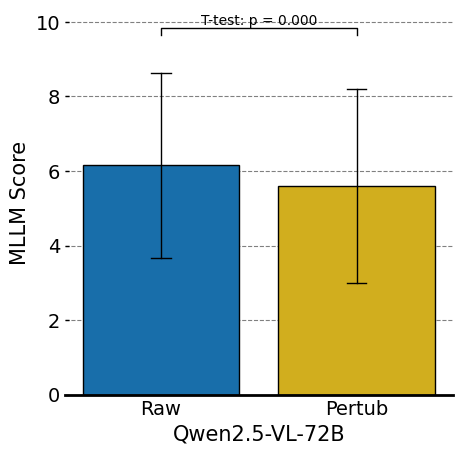

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind

data = {
    "Qwen2.5-VL-72B": ["Raw"] * len(scores_original) + ["Pertub"] * len(scores_remove_reflection),
    "MLLM Score": scores_original + scores_remove_reflection
}
df = pd.DataFrame(data)

# 计算 t 检验的 p-value
t_stat, p_val = ttest_ind(scores_original, scores_remove_reflection, equal_var=False)
p_value_text = f"p = {p_val:.3f}"

# 设置绘图参数
plt.rcParams["axes.labelsize"] = 15
palette = ['#0073C2FF', '#EFC000FF']

fig, ax = plt.subplots(figsize=(5, 5), dpi=100, facecolor="w")
ax = sns.barplot(
    x="Qwen2.5-VL-72B", y="MLLM Score", data=df, palette=palette,
    estimator=np.mean, ci="sd", capsize=.1, errwidth=1, errcolor="k",
    ax=ax, edgecolor="k", linewidth=1
)

# 添加 p-value 标注
x1, x2 = 0, 1  # 两个类别在 x 轴上的位置
# 确定标注线的高度：取两个组均值加标准差中的最大值，再加上一些偏移
y = max(np.mean(scores_original) + np.std(scores_original), np.mean(scores_remove_reflection) + np.std(scores_remove_reflection)) + 1
h = 0.2  # 横线的高度偏移
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
ax.text((x1+x2)*.5, y+h, "T-test: " + p_value_text, ha='center', va='bottom', color="k")

# 调整坐标轴和网格
ax.tick_params(which='major', direction='in', length=3, width=1., labelsize=14, bottom=False)
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.grid(axis='y', ls='--', c='gray')
ax.set_axisbelow(True)
plt.savefig("/cpfs04/user/hanyujin/rule-gen/rule_tokenizer/eval/mllmscore/mmlmscore_Qwen2.5-VL-72B-Instruct.png")
plt.show()


In [5]:
import numpy as np
np.mean(scores_original)

7.58

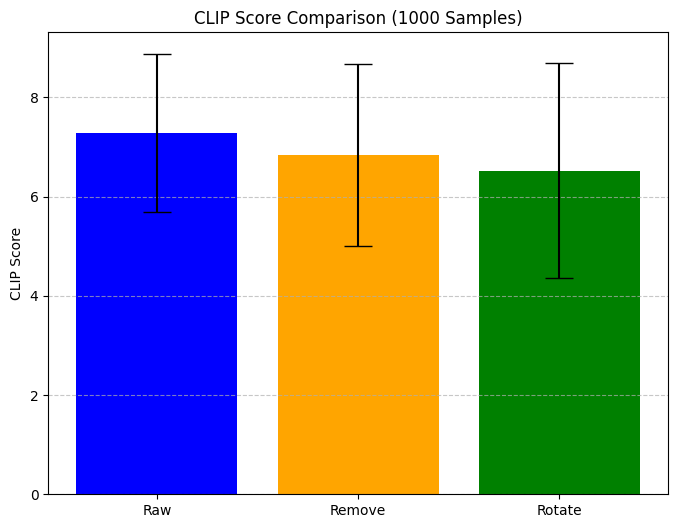

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 假设这三个列表已经定义
# scores_original, scores_remove_reflection, scores_rotation

# 计算每个列表的均值和标准差
data = [scores_original, scores_remove_reflection, scores_rotation]
labels = ["Raw", "Remove", "Rotate"]

means = [np.mean(d) for d in data]
stds = [np.std(d) for d in data]

plt.figure(figsize=(8, 6))
plt.bar(labels, means, yerr=stds, capsize=10, color=["blue", "orange", "green"])
plt.ylabel("CLIP Score")
plt.title("CLIP Score Comparison (1000 Samples)")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
# plt.savefig("/cpfs04/user/hanyujin/rule-gen/rule_tokenizer/eval/mllmscore/mmlmscore.png")
plt.show()


In [1]:
import os
import random
import torch
import re
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, Qwen2VLForConditionalGeneration
from qwen_vl_utils import process_vision_info

# 配置参数
model_name = "QVQ-72B-Preview"
local_path = f"/cpfs04/shared/CausaLLMs/HuggingfaceModels/{model_name}"
image_size = 64
batch_size = 8  # 设定批处理大小，可根据显存调整
device = "cuda" if torch.cuda.is_available() else "cpu"

# 加载模型
if model_name == "Qwen2.5-VL-72B-Instruct" or model_name == "Qwen2.5-VL-7B-Instruct":
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        local_path, torch_dtype="auto", device_map="auto"
    )
elif model_name == "QVQ-72B-Preview":
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        local_path, torch_dtype="auto", device_map="auto"
    )

processor = AutoProcessor.from_pretrained(local_path)


# 自定义 Dataset
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_size):
        self.image_paths = image_paths
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        return image_path


# 处理批量图片并评分
def evaluate_images_in_batch(image_paths):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path, "resized_height": image_size, "resized_width": image_size}
                for image_path in image_paths
            ] + [
                {"type": "text", "text": (
                    f"You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. "
                    f"You will see {batch_size} images of an object in front of a mirror and its reflection. Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. "
                    "Please rate each image individually on a scale from 0 (inconsistent) to 10 (completely harmonious and consistent). The specific scoring criteria are as follows:"
                    "Score 10: Perfect match in shape and outline, considering the mirror flip."  
                    "Score 9: Minor distortions due to perspective, but overall shape is recognizable."  
                    "Score 8: Slight inconsistencies in shape, possibly due to object positioning or minor defects."  
                    "Score 7: Moderate inconsistencies, where the general shape is similar but there are noticeable differences."  
                    "Score 6: Significant inconsistencies, making it hard to recognize the reflection as the object’s reflection."  
                    "Score 5: Equal parts consistent and inconsistent, borderline case."  
                    "Score 4: Reflection shows a completely different shape, but some elements are similar."  
                    "Score 3: Reflection bears little resemblance to the object."  
                    "Score 2: Only a few parts of the reflection match the object."  
                    "Score 1: Almost no similarity in shape and outline."  
                    "Score 0: Reflection is completely different, no similarity at all."
                    "Please think this step by step and answer in the the format: The score is {your_score}. The reason is {your_reason}."
                )}
            ],
        }
    ]

    # 预处理输入
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    # 生成输出
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=9000)

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_texts = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    # 解析评分
    scores = []
    for output_text in output_texts:
        score = extract_score_after_final_answer(output_text)
        scores.append(score)

    return scores


def extract_score_after_final_answer(output_text):
    """ 从模型输出文本中提取最终评分 """
    pattern = r"\*\*Final Answer\*\*.*?(\d+)"
    match = re.search(pattern, output_text, re.DOTALL)

    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"No number found after **Final Answer** in: {output_text}")


# 读取图片路径
image_dirs = [
    "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left",
    "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0",
    "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0"
]

image_paths = []
for image_dir in image_dirs:
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]
    image_paths.extend(random.sample(image_files, min(10, len(image_files))))  # 采样10张图片

# 创建 DataLoader
dataset = ImageDataset(image_paths, image_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 批量评分
scores = []
for batch in tqdm(dataloader, desc="Processing Batches"):
    try:
        batch_scores = evaluate_images_in_batch(batch)
        scores.extend(batch_scores)
    except Exception as e:
        print(f"Error processing batch: {e}")

# 输出最终评分
print("Final image scores:", scores)


/root/miniconda3/envs/yjenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-25 10:52:52.221996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 10:52:52.244759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742871172.263006 3517069 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742871172.268269 3517069 cuda_blas.cc:1407] Un

Error processing batch: No number found after **Final Answer** in: Alright, I've got this task where I need to look at images of objects in front of a mirror and evaluate if their shape and outline match their reflection. I should ignore colors and textures and just focus on the shape and outline. I have to rate each image on a scale from 0 to 10.

First, I need to understand what exactly is being asked. The object is placed in front of a mirror, and there's a reflection. I need to check if the reflection accurately represents the shape and outline of the object. So, basically, I need to see if the mirror is showing the correct form of the object.

I should consider things like symmetry, angles, and proportions. If the object is symmetrical, its reflection should match perfectly. If it's asymmetrical, I need to make sure that the reflection corresponds correctly to the object's shape.

Let me think about how mirrors work. A mirror reflects light, and the image it produces is a virtual 

Processing Batches: 100%|██████████| 4/4 [19:28<00:00, 292.14s/it]

Final image scores: [0, 10, 0]
